# 📈 Exploration 14 Main Project : 주식 예측 📉

## 🎯 루브릭 살펴보기 🎯

|루브릭 평가항목|세부기준|
|------|---|
|<span style="color:red">**시계열의 안정성이 충분히 확인되는가?**</span>|플로팅과 adfuller 메소드가 모두 적절한 때에 사용되었을 것|
|<span style="color:blue">**ARIMA 모델 모수선택 근거를 체계적으로 제시하는가?**</span>|p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 나타날 것|
|<span style="color:purple">**예측 모델의 오차율이 기준 이하로 나오는가?**</span>|3개 이상 종목이 MAPE 15% 미만의 정확도로 예측되도록 설정할 수 있을 것|

## 🎆 프로젝트 순서 🎆

- 이번 프로젝트는 필요한 라이브러리가 생길 때마다 그때그때 import 해줄 것이다.

1. 시계열 데이터 준비
2. 데이터 전처리
3. 시계열 안정성 분석
4. Train / Test 데이터셋 생성
5. 적정 ARIMA 모수 찾기
6. ARIMA 모델 Training / Testing
7. 특명 : 다른 주식 종목 예측하기
8. 프로젝트 회고

## 1. 시계열 데이터 준비

- 칼럼 종류로는 **Date, Open, High, Low, Close, Adj Close, Volume**이 있다.
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있다.
- 우리는 하루의 장이 마감하였을 때의 가격지표인 **종가(Close)** 만 사용한다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

- **rcParams**를 활용하여 시계열 데이터를 차트로 나타내 본다.

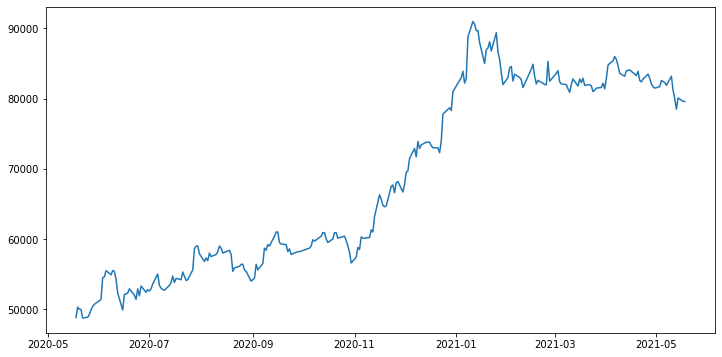

In [2]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 6    # matlab 차트의 기본 크기를 12, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

## 2. 데이터 전처리

- 노드에서 언급한 **결측치 처리** 및 **로그 변환** 방법을 이용해 데이터를 전처리한다.

In [3]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

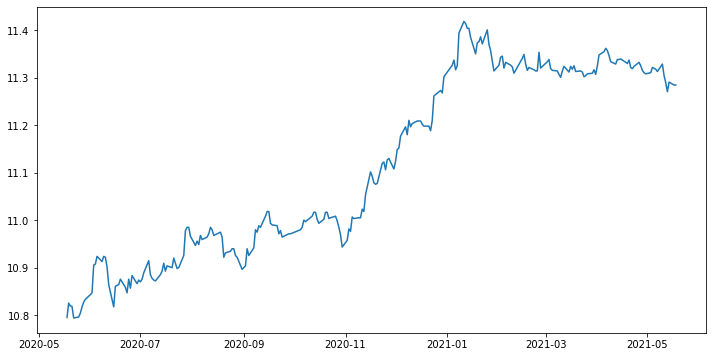

In [4]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

## 3. 시계열 안정성 분석

- 위의 그래프로 미루어 보아, 이 데이터셋은 월단위로 값이 변화하는 시계열이므로 window의 값을 12로 설정한다.
- 원본 데이터와 이동평균 간의 편차가 거의 없는 것으로 보아, 위 시계열은 안정성이 있음을 알 수 있다!

In [5]:
# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화하는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

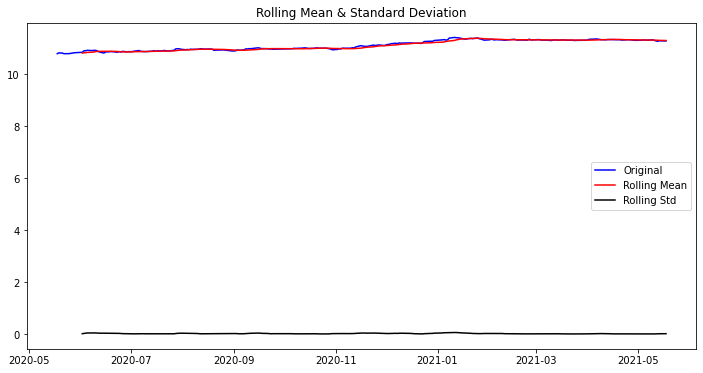

In [6]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

- **statsmodels** 패키지는 R에서 제공하는 통계검정, 시계열 분석 등의 기능을 파이썬에서도 이용할 수 있도록 하는 패키지이다.
- statsmodels 패키지에서 제공하는 **adfuller** 메소드를 이용해, **주어진 timeseries에 대한 정량적 Augmented Dickey-Fuller Test를 수행한다.**
- Dickey-Fuller Test가 뭐에요? (https://blog.naver.com/gudwls9330/222077057188)
- **Dickey-Fuller Test**는 확률변수의 안정성을 확인하는 방법이다.
- **ARIMA 모델**은 시계열 데이터가 안정적인 상태에서 효과적이므로, 데이터가 안정성을 가지는지 확인할 필요가 있다.

In [7]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [8]:
# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


- **시계열 분해**를 수행한다.

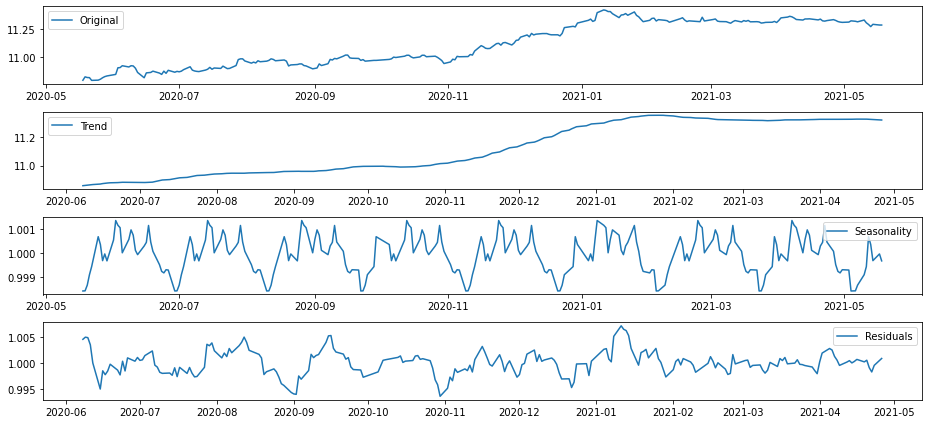

In [9]:
# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (13,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

- 마지막으로 **Residual의 안정성**을 확인한다.
- **p-value의 값이 작으면 작을수록** 귀무가설을 지지하는 정도가 약해져 귀무가설을 기각하게 된다.
- Residual이 안정성이 있다고 주장하는 것은 **대립가설**에 해당하게 된다.
- 아래 코드를 실행한 결과의 **p-value는 0에 가까운 매우 작은 값**이다.
- 따라서 **귀무가설을 기각**하고 대립가설을 받아들이게 되어, 예측하는 데 있어 안정적인 시계열 데이터가 된다.

In [10]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


## 4. Train / Test 데이터셋 생성

- 분리 비율을 **Train : Test = 9 : 1**로 설정하겠다.
- 시계열 예측에서는 **가장 나중의 데이터를 Test 데이터셋으로 사용**하는 것이 좋다.

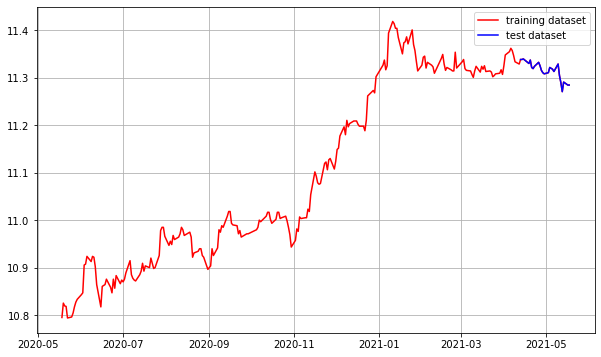

In [11]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

- 분리된 Train, Test 데이터셋의 형태를 확인해 본다.

In [12]:
print(ts_log[:5])
print(train_data.shape)   # Train 데이터셋의 형태
print(test_data.shape)    # Test 데이터셋의 형태

Date
2020-05-18    10.795486
2020-05-19    10.825760
2020-05-20    10.819778
2020-05-21    10.818778
2020-05-22    10.794460
Name: Close, dtype: float64
(225,)
(25,)


## 5. 적정 ARIMA 모수 찾기

- 근거에 기반하여 적정 ARIMA 모수를 찾는 과정을 수행한다.
- ACF, PACF를 이용해 p와 q를 구하고, 차분의 안정성을 상징하는 d를 구한다.
- 아래 코드를 분석해 보면, **PACF 그래프에서 p=2 시점부터 로그 값이 0에 가까워지고 있음**을 파악 가능하다.
- 따라서 **적합한 p의 값으로 1**이 적합하다.
- PACF가 0이라는 것은 현재 시점으로부터 p 시점 떨어진 곳 이전의 데이터부터는 아무런 상관이 없는 데이터라는 의미를 갖는다.
- **ACF는 점차적으로 감소 추세**를 나타내고 있으므로 결국 이 모델은 **AR(1) 모델에 유사한 형태**라고 볼 수 있다.
- **MA 모형을 고려하지 않는다면 q=0**으로 두고 할 수도 있지만, q의 값을 바꾸어 가며 확인해 보는 것도 나쁘지 않은 실험이다.

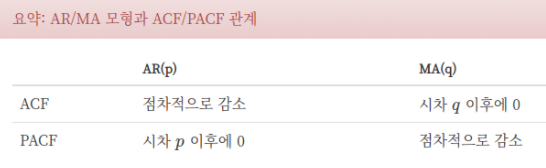

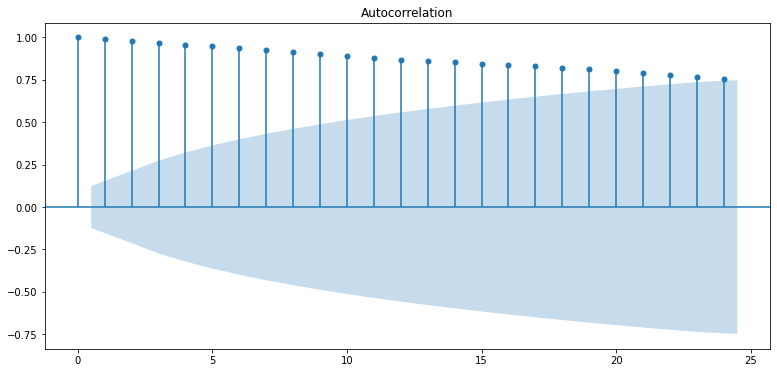

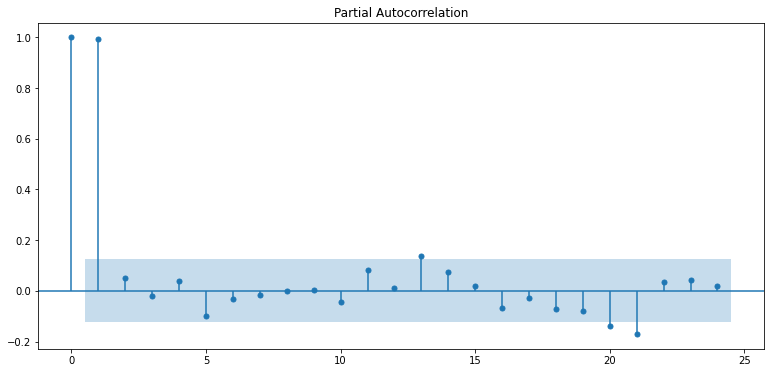

In [13]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- **p-value의 값이 작을수록 안정성이 더 강하다는 점**을 들어 몇 차 차분일 때 안정성이 더 큰지를 판단해 본다.
- 1, 2차 차분으로만 판단해보면 **1차일 때가 2차일 때보다 p-value 값이 작았음**을 알 수 있다.
- 따라서 해당 모델에 적절한 d의 값은 1이라고 볼 수 있다.
- 아래는 1, 2차 차분의 결과를 요약 및 그래프로 나타낸 것이다.

- **1차 차분**

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


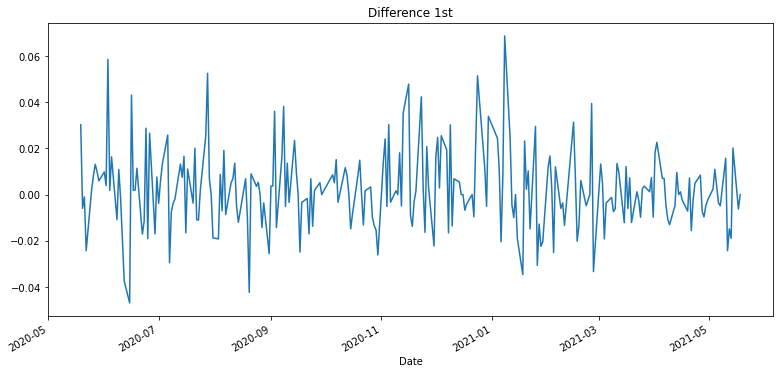

In [14]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

- **2차 차분**

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


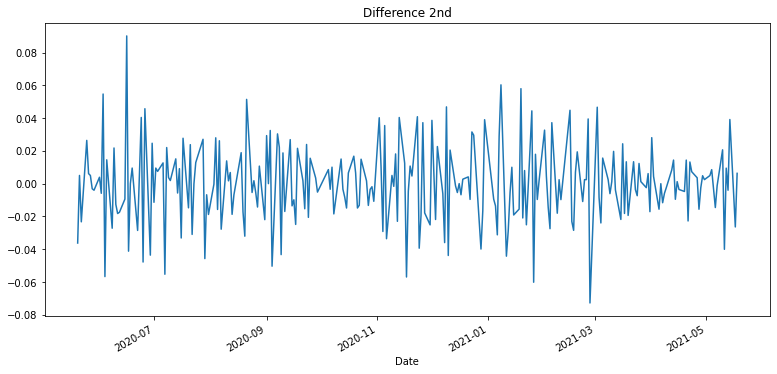

In [15]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## 6. ARIMA 모델 Training / Testing

- **ARIMA는 아래의 3가지 모수를 가진다.**
1. **p** : 자기회귀 모형(AR)의 시차
2. **q** : 이동평균 모형(MA)의 시차
3. **d** : 누적 차분 횟수

- 여기에서는 **p=1, d=1, q=1을 모수로 가지는 ARIMA 모델**을 가지고 훈련을 해볼 것이다.

In [16]:
from statsmodels.tsa.arima_model import ARIMA

#Build Model
model = ARIMA(train_data, order=(1, 1, 1))  

#fitting model
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 585.409
Method:                       css-mle   S.D. of innovations              0.018
Date:                Sun, 05 Sep 2021   AIC                          -1162.819
Time:                        07:53:11   BIC                          -1149.172
Sample:                             1   HQIC                         -1157.310
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      1.980      0.048    2.38e-05       0.005
ar.L1.D.Close    -0.2064      1.325     -0.156      0.876      -2.803       2.390
ma.L1.D.Close     0.2260      1.318     

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

- ARIMA 모델의 훈련 결과를 시각적으로 확인해 본다.
- 대체로 이 모델이 안정적으로 예측하였음을 확인할 수 있다.

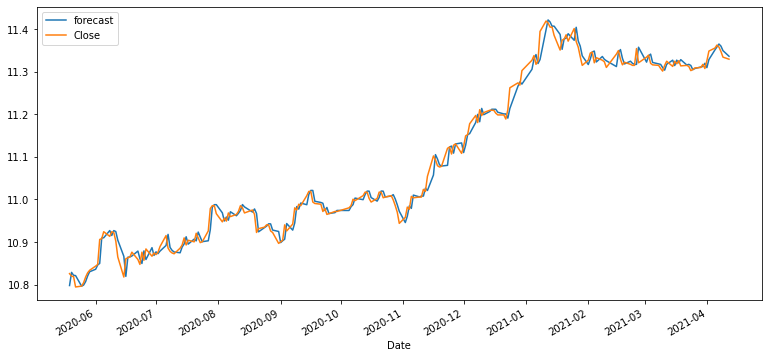

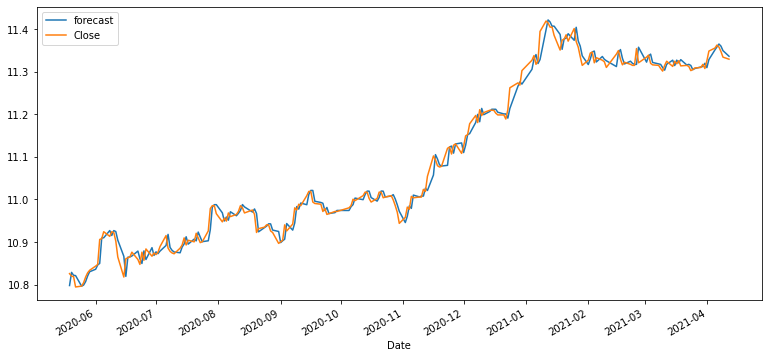

In [17]:
fitted_m.plot_predict()

- **forecast()** 메소드를 이용하면 Test 데이터 구간의 데이터를 예측할 수 있다.

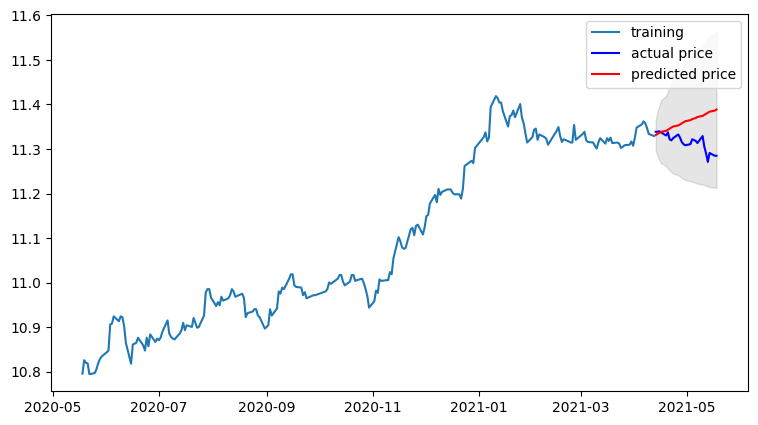

In [18]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

- 그런데 우리는 **시계열 데이터를 로그 변환**해 사용하였으므로, 원래의 데이터로 원복하기 위해서 **지수 변환을 사용하여 정확한 오차를 계산한다.**
- 계산 결과 **MAPE가 무려 4.68%** 를 나타냈다! q의 값을 매우 잘 설정한 것일..까!!! 😅😅😅
- 사실 아닐 수도 있다. 이 데이터셋이 전체적으로 봤을 때는 증가 추세이며 나타난 기간의 범위가 1년인 것도 영향이 있을지도 모른다.
- 다음 특명 프로젝트에서 다른 관심 종목에 대해 동일 과정을 시행하며 MAPE를 예측해 본다!

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  22124900.384517975
MAE:  3795.2033017645904
RMSE:  4703.7113415385065
MAPE: 4.68%


## 7. 특명 : 다른 주식 종목 예측하기

- 지금까지의 과정을 다른 주식 종목에 적용하여 같은 방법으로 예측해 보고자 한다.
- 복수의 주식 종목에 대해 예측을 시행해야 하는 관계로 부득이하게 **함수로 구현한다.**

In [20]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

print('라이브러리 import 완료!')

라이브러리 import 완료!


In [21]:
def get_time_series_log(filename):
    # Time Series 생성
    dataset_dirpath = os.getenv('HOME') + '/aiffel/stock_prediction/pdata'   # 만일 경로가 다르다면 경로를 수정하면 된다.
    dataset_filepath = os.path.join(dataset_dirpath, filename)
    df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
    ts = df['Close']
    # 결측치 처리
    if len(ts[ts.isna()]) > 0:
        ts = ts.interpolate(method='time')
    # 로그 변환
    return np.log(ts)

In [22]:
# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화하는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    rcParams['figure.figsize'] = 10, 6
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [23]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [24]:
## 안정성 여부를 확인하기 위한 방법!
def check_stationary(ts_log):
    # 정성적 그래프 분석
    plot_rolling_statistics(ts_log, window=12)
    # 정량적 Augmented Dicky-Fuller Test
    augmented_dickey_fuller_test(ts_log)

In [25]:
def time_series_decomposition(ts_log):
    # 시계열 분해 (Time Series Decomposition)
    decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.rcParams["figure.figsize"] = (12,6)
    plt.subplot(411)
    plt.plot(ts_log, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    
    # Residual 안정성 확인
    residual.dropna(inplace=True)
    augmented_dickey_fuller_test(residual)

In [26]:
# Train / Test 데이터셋 분리
def split_train_test_data(ts_log):
    train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
    plt.plot(test_data, c='b', label='test dataset')
    plt.legend()
    return train_data, test_data

In [27]:
# ACF, PACF 그려보기 -> p,q 구하기
def plot_acf_pacf(ts_log):
    plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
    plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
    plt.show()

In [28]:
# 차분 안정성 확인 -> d 구하기
def get_difference(ts_log):
    # 1차 차분 구하기
    plt.subplot(211)
    diff_1 = ts_log.diff(periods=1).iloc[1:]
    diff_1.plot(title='Difference 1st')
    # 혹시 필요한 경우 2차 차분 구하기
    plt.subplot(212)
    diff_2 = diff_1.diff(periods=1).iloc[1:]
    diff_2.plot(title='Difference 2nd')

    print('Difference 1st:')
    augmented_dickey_fuller_test(diff_1)
    print('\nDifference 2nd:')
    augmented_dickey_fuller_test(diff_2)

In [29]:
## 모델 테스트 및 최종 MAPE 오차율 구하기
def arima_train_test(order):
    # Build and Train  Model
    model = ARIMA(train_data, order=order)
    fitted_m = model.fit(disp=-1)
    print(fitted_m.summary())

    # Forecast : 결과가 fc에 담깁니다. 
    fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
    lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
    upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

    # Plot
    plt.figure(figsize=(10,6), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
    plt.legend()
    plt.show()

    # Score
    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('MSE: ', mse)
    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)
    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('RMSE: ', rmse)
    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape*100))

### 💛 Naver 💛

- **표준편차(Rolling Std)가 0에 수렴**하고 있는 것으로 보아, 이 데이터셋은 안정성이 있는 데이터셋인 것 같다.

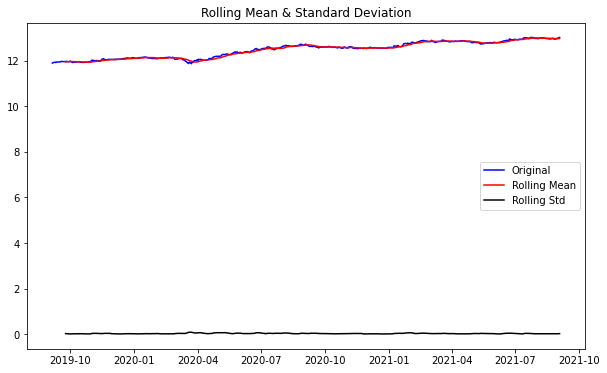

Results of Dickey-Fuller Test:
Test Statistic                  -0.805331
p-value                          0.817551
#Lags Used                       1.000000
Number of Observations Used    493.000000
Critical Value (1%)             -3.443684
Critical Value (5%)             -2.867420
Critical Value (10%)            -2.569902
dtype: float64


In [32]:
# Time Series 생성하기
ts_log = get_time_series_log('naver.csv')

# 정성적, 정량적 시계열 안정성 분석
check_stationary(ts_log)

- 시계열 분해 과정을 통해 얻은 p-value의 값은 0에 매우 근접한 값이다.

Results of Dickey-Fuller Test:
Test Statistic                -8.087213e+00
p-value                        1.409306e-12
#Lags Used                     7.000000e+00
Number of Observations Used    4.570000e+02
Critical Value (1%)           -3.444740e+00
Critical Value (5%)           -2.867885e+00
Critical Value (10%)          -2.570150e+00
dtype: float64


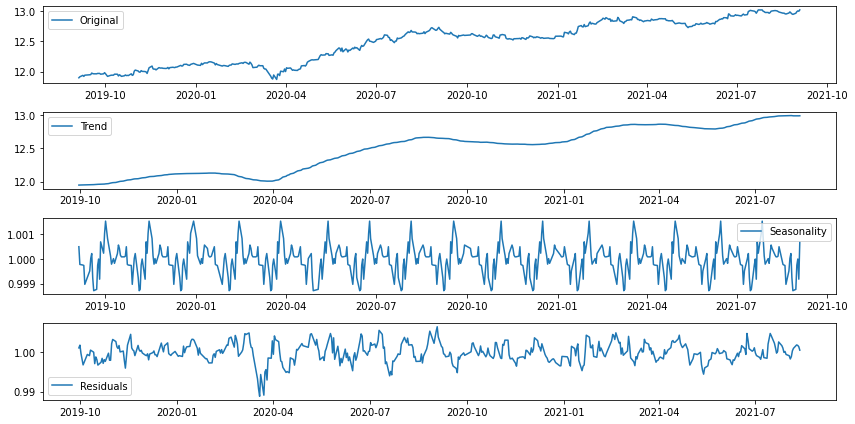

In [33]:
# 시계열 분해
time_series_decomposition(ts_log)

- Train / Test 데이터셋을 9:1로 분리한다.

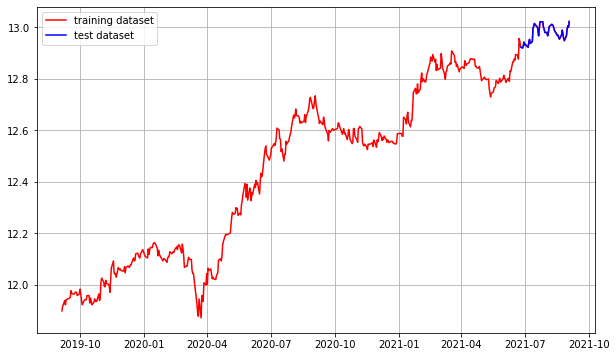

In [34]:
train_data, test_data = split_train_test_data(ts_log)

- ARIMA 모델의 모수를 선택하기 위한 과정이다.
- ACF, PACF 그래프로 보아 p=1을 선택할 수 있을 것 같다.

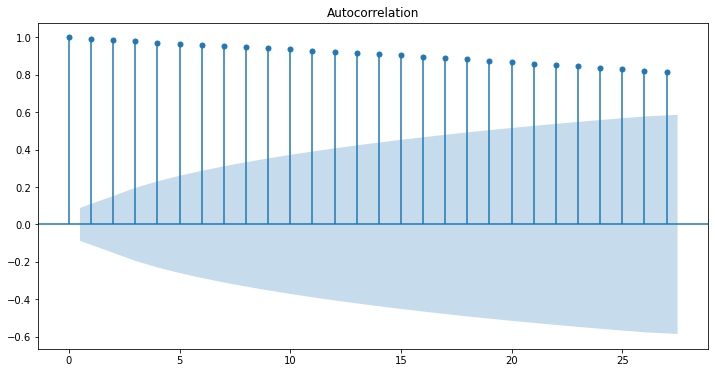

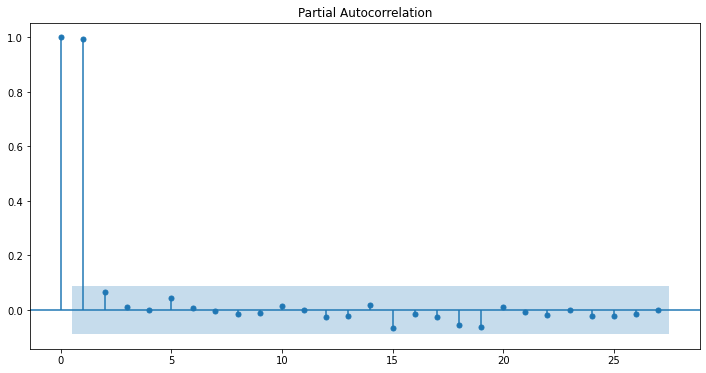

In [35]:
# ACF, PACF 그려보기 -> p,q 구하기
plot_acf_pacf(ts_log)

- 1차 차분에서는 컴퓨터 계산에서 자릿수 표시 문제 또는 p-value가 극도로 작은 값이 나와서 그런지는 모르겠지만 **0이 나왔다.**
- 2차 차분에서는 다시 p-value의 값이 0에 근접하는 모습을 보인다.
- 아래 코드의 흐름으로 보아, d=1을 선택하는 것이 가장 적합해 보인다.

Difference 1st:
Results of Dickey-Fuller Test:
Test Statistic                 -24.518563
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    493.000000
Critical Value (1%)             -3.443684
Critical Value (5%)             -2.867420
Critical Value (10%)            -2.569902
dtype: float64

Difference 2nd:
Results of Dickey-Fuller Test:
Test Statistic                -1.038629e+01
p-value                        2.075909e-18
#Lags Used                     1.500000e+01
Number of Observations Used    4.770000e+02
Critical Value (1%)           -3.444134e+00
Critical Value (5%)           -2.867618e+00
Critical Value (10%)          -2.570008e+00
dtype: float64


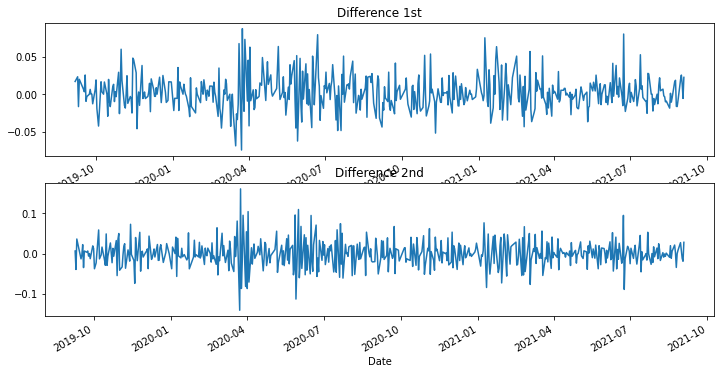

In [36]:
# 차분 안정성 확인 -> d 구하기
get_difference(ts_log)

- 이제 ARIMA 모델의 훈련 및 테스트를 진행해 본다.
- p=1, d=1, q=1
- **MAPE 결과값 : 4.02%**

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  444
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1043.248
Method:                       css-mle   S.D. of innovations              0.023
Date:                Sun, 05 Sep 2021   AIC                          -2078.497
Time:                        08:17:39   BIC                          -2062.114
Sample:                             1   HQIC                         -2072.036
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      2.383      0.017       0.000       0.004
ar.L1.D.Close    -0.2235      0.397     -0.562      0.574      -1.002       0.555
ma.L1.D.Close     0.1072      0.405     

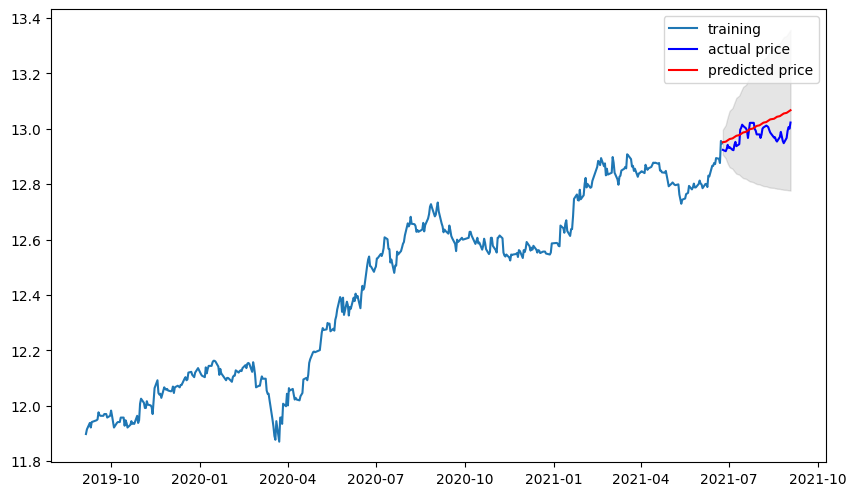

MSE:  433148888.38924354
MAE:  17296.81048851257
RMSE:  20812.22929888203
MAPE: 4.02%


In [37]:
# ARIMA 모델 훈련 및 테스트 (각각은 p, d, q로 대응)
arima_train_test((1, 1, 1))

### 💛 롯데(LOTTE) 💛

- 이번에도 Naver와 마찬가지로 표준편차가 0에 수렴하는 것으로 보아, 안정성은 있는 것 같다.

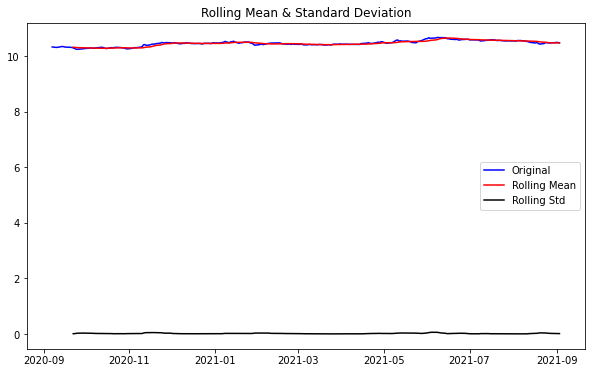

Results of Dickey-Fuller Test:
Test Statistic                  -1.781327
p-value                          0.389771
#Lags Used                       0.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


In [38]:
# Time Series 생성하기
ts_log = get_time_series_log('lotte.csv')

# 정성적, 정량적 시계열 안정성 분석
check_stationary(ts_log)

- 시계열 분해 과정을 통해 얻은 p-value 값은 이전의 Naver보다는 조금 더 높게 나왔다.
- 하지만 p-value는 0에 매우 가까운 값이므로 귀무가설을 기각하여 안정성이 보장되는 시계열 데이터셋임을 알 수 있다.

Results of Dickey-Fuller Test:
Test Statistic                  -4.978349
p-value                          0.000024
#Lags Used                       0.000000
Number of Observations Used    216.000000
Critical Value (1%)             -3.460992
Critical Value (5%)             -2.875016
Critical Value (10%)            -2.573952
dtype: float64


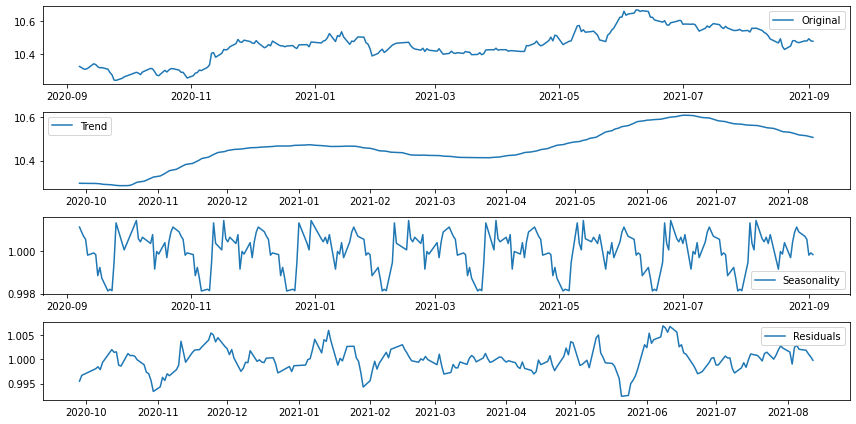

In [39]:
# 시계열 분해
time_series_decomposition(ts_log)

- 이번에도 Train, Test 데이터셋을 9:1로 분리한다.

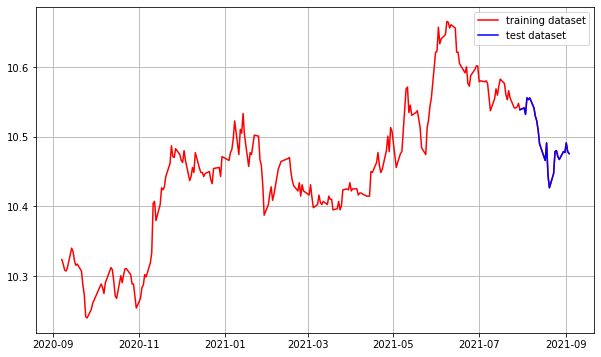

In [40]:
train_data, test_data = split_train_test_data(ts_log)

- ARIMA 모델의 모수를 선택하기 위한 과정이다.
- 이번에도 ACF 그래프는 감소 추이를 보였다.
- PACF 그래프로 미루어 보아, p=1을 선택할 수 있다.

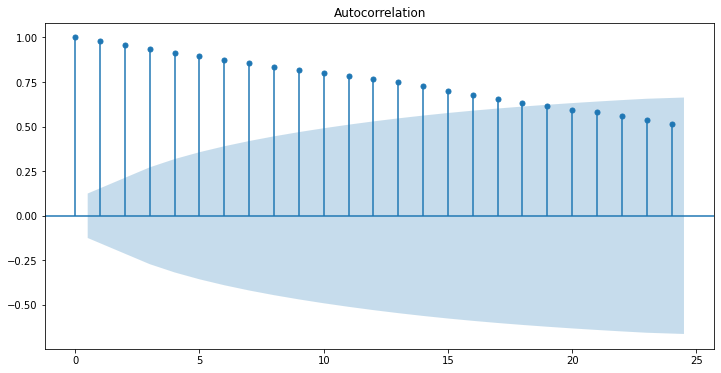

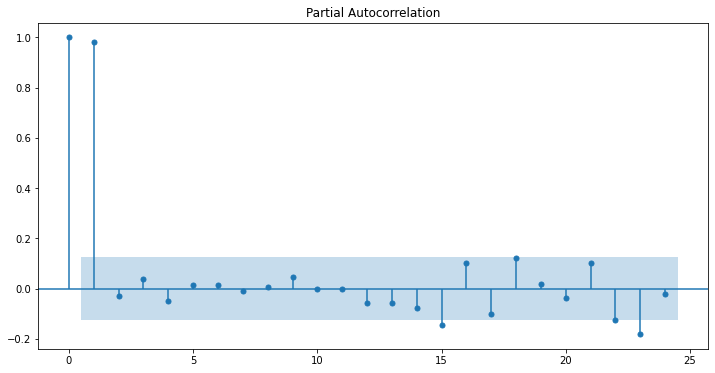

In [41]:
# ACF, PACF 그려보기 -> p,q 구하기
plot_acf_pacf(ts_log)

- 누적 차분을 나타내는 d의 값으로는 역시 1이 적절하다. (**e-28 < e-10**)

Difference 1st:
Results of Dickey-Fuller Test:
Test Statistic                -1.550955e+01
p-value                        2.358271e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64

Difference 2nd:
Results of Dickey-Fuller Test:
Test Statistic                -7.239978e+00
p-value                        1.895495e-10
#Lags Used                     1.400000e+01
Number of Observations Used    2.300000e+02
Critical Value (1%)           -3.459106e+00
Critical Value (5%)           -2.874190e+00
Critical Value (10%)          -2.573512e+00
dtype: float64


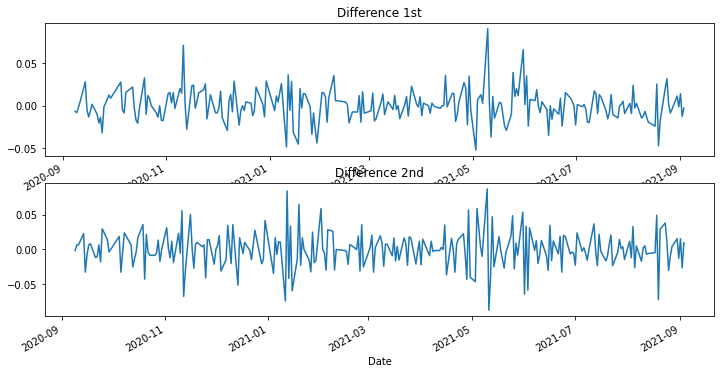

In [42]:
# 차분 안정성 확인 -> d 구하기
get_difference(ts_log)

- 이제 ARIMA 모델의 훈련 및 테스트를 진행해 본다.
- p=1, d=1, q=1
- **MAPE 결과값 : 8.42%**
- 앞의 두 모델에 비해 MAPE 결과값이 높게 나온 이유는 아무래도 실제 price 값과 예측 price 사이의 차이가 컸기 때문이라고 판단한다.

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  221
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 570.391
Method:                       css-mle   S.D. of innovations              0.018
Date:                Sun, 05 Sep 2021   AIC                          -1132.781
Time:                        08:36:20   BIC                          -1119.188
Sample:                             1   HQIC                         -1127.293
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0012      0.000      3.745      0.000       0.001       0.002
ar.L1.D.Close     0.9528      0.022     42.393      0.000       0.909       0.997
ma.L1.D.Close    -1.0000      0.011    -

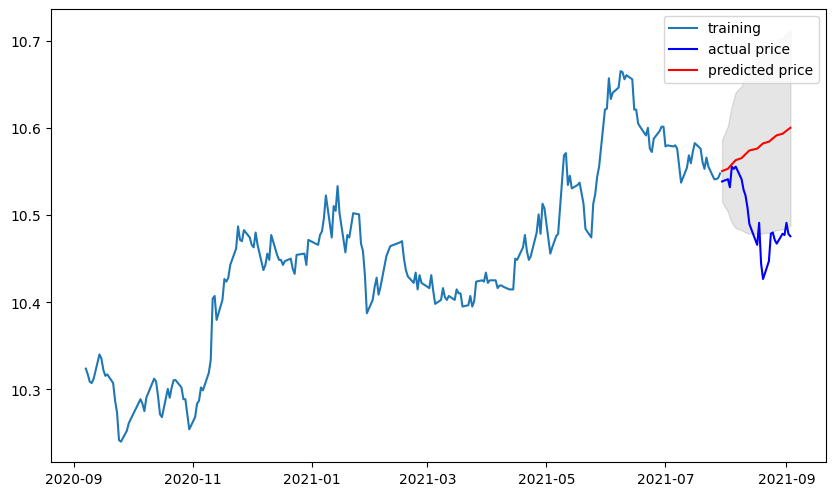

MSE:  12220329.193493642
MAE:  2983.985663356076
RMSE:  3495.7587436054055
MAPE: 8.42%


In [58]:
# ARIMA 모델 훈련 및 테스트
arima_train_test((1, 1, 1))

### 💛 현대모비스 💛

- 이 데이터셋의 경우 2021년 1월 초중순쯤에 원래 데이터와 이동평균 간의 차이가 조금 있는 부분이 있으나, 전반적으로 표준편차가 0에 수렴하는 모습을 볼 수 있다. 따라서 안정성이 있는 데이터셋으로 본다.

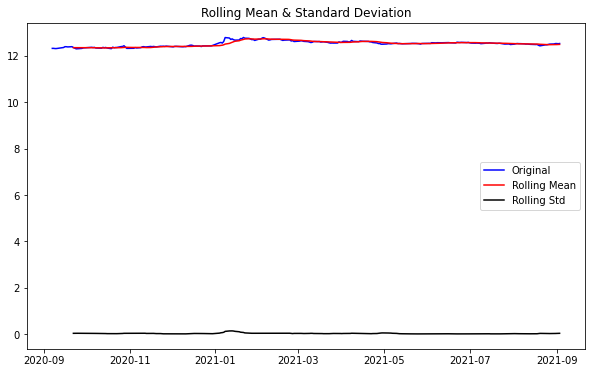

Results of Dickey-Fuller Test:
Test Statistic                  -2.031427
p-value                          0.272966
#Lags Used                       2.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64


In [60]:
# Time Series 생성하기
ts_log = get_time_series_log('hyundaimobis.csv')

# 정성적, 정량적 시계열 안정성 분석
check_stationary(ts_log)

- p-value가 0.05보다 작으므로 귀무가설이 기각될 확률이 높다고 볼 수 있다.

Results of Dickey-Fuller Test:
Test Statistic                  -3.218123
p-value                          0.018959
#Lags Used                      14.000000
Number of Observations Used    202.000000
Critical Value (1%)             -3.463144
Critical Value (5%)             -2.875957
Critical Value (10%)            -2.574455
dtype: float64


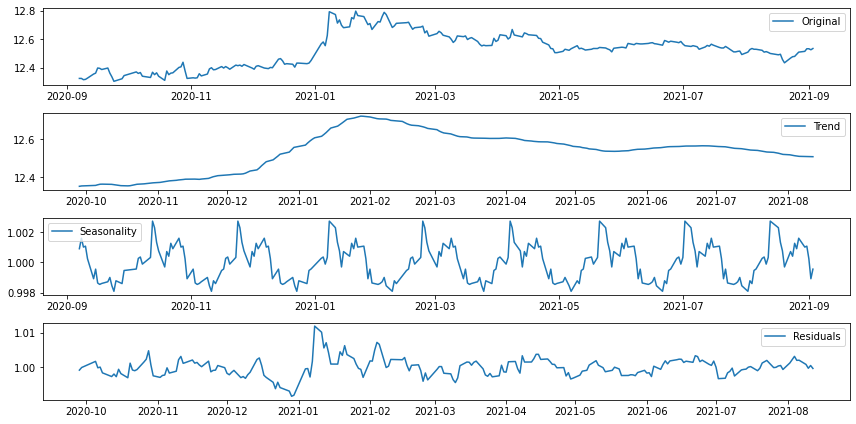

In [61]:
# 시계열 분해
time_series_decomposition(ts_log)

- Train / Test 데이터셋을 9:1로 분리한다.

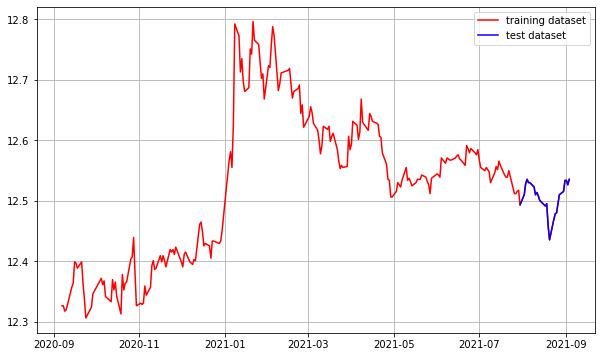

In [62]:
train_data, test_data = split_train_test_data(ts_log)

- 아래는 ARIMA 모델의 모수를 선택하는 과정이다.
- 이번에도 p=1을 선택한다. p=2 부터 값이 0에 가까워지기 때문이다.

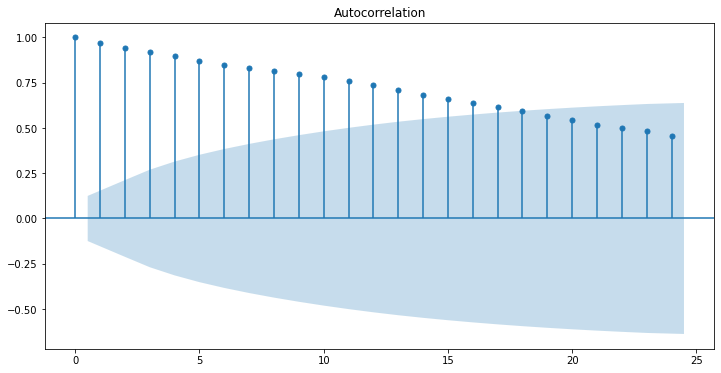

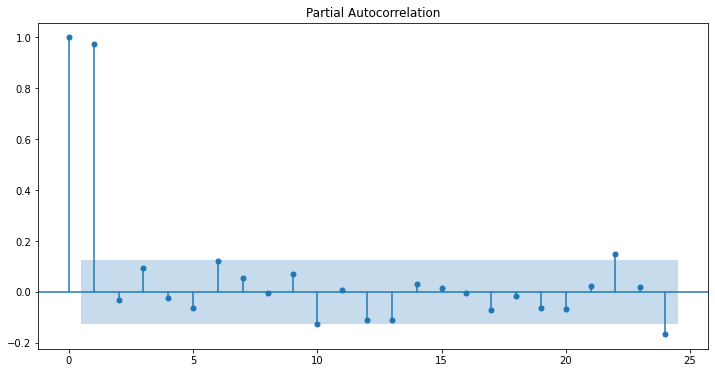

In [63]:
# ACF, PACF 그려보기 -> p,q 구하기
plot_acf_pacf(ts_log)

- 누적 차분을 나타내는 d의 값으로 1이 적절하다. (**e-23 < e-15**)

Difference 1st:
Results of Dickey-Fuller Test:
Test Statistic                -1.241218e+01
p-value                        4.318949e-23
#Lags Used                     1.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64

Difference 2nd:
Results of Dickey-Fuller Test:
Test Statistic                -9.120715e+00
p-value                        3.210901e-15
#Lags Used                     1.000000e+01
Number of Observations Used    2.340000e+02
Critical Value (1%)           -3.458608e+00
Critical Value (5%)           -2.873972e+00
Critical Value (10%)          -2.573396e+00
dtype: float64


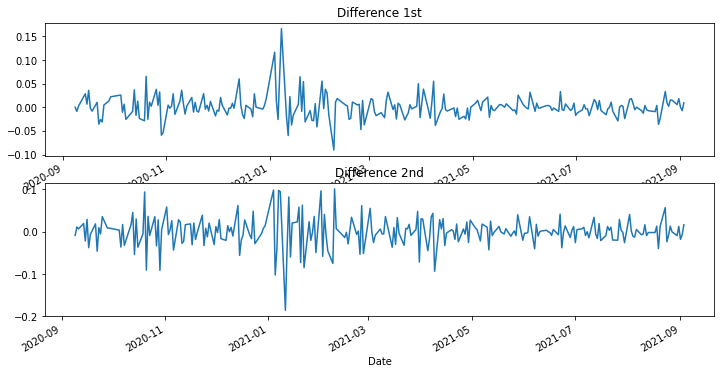

In [64]:
# 차분 안정성 확인 -> d 구하기
get_difference(ts_log)

- 이제 ARIMA 모델의 훈련 및 테스트를 진행해 본다.
- 놀랍게도 **MAPE 오차율이 2.68%** 를 기록했다! 😄😄

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  221
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 494.833
Method:                       css-mle   S.D. of innovations              0.026
Date:                Sun, 05 Sep 2021   AIC                           -981.667
Time:                        08:52:38   BIC                           -968.074
Sample:                             1   HQIC                          -976.178
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0009      0.002      0.490      0.624      -0.003       0.004
ar.L1.D.Close    -0.8138      0.347     -2.347      0.019      -1.493      -0.134
ma.L1.D.Close     0.8511      0.313     

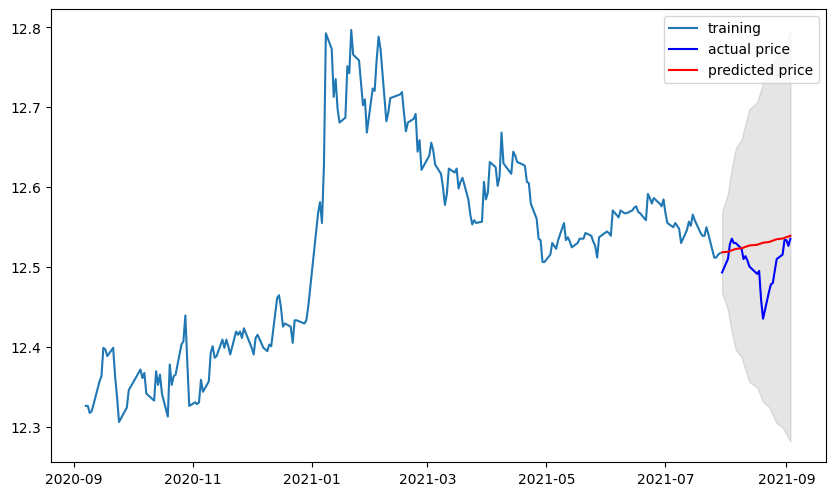

MSE:  90172806.82932729
MAE:  7079.065975698294
RMSE:  9495.93633241753
MAPE: 2.68%


In [65]:
# ARIMA 모델 훈련 및 테스트
arima_train_test((1, 1, 1))

## 8. 프로젝트 회고

- 연습 종목 및 7번에서 활용한 주식 종목들 모두 1차 차분일 때가 2차 차분일 때보다 p-value의 값이 더 높았다.
- 이번 프로젝트에서는 최근 1~2년치 데이터만을 가지고 주식예측을 진행했다.
- ARIMA 모델은 시계열 데이터가 안정적일 수록 좋은 Output을 가져올 수 있다.
- 좀 더 다양하게 조작해서 ARIMA 모델을 테스트해보고 싶었지만, 시간 관계상 여기서 마치고자 한다.